This scripts reproduces the relax pattern analysis using likelihood ratio test DEGs called by sleuth.
LR should be more appropriate than Wald, as mentioned by developpers.

In [1]:
import pandas, numpy, termcolor, seaborn, colorutils
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_sleuth/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/sleuth_TPM_gene.csv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

In [4]:
# necio5
DEG_folder = '/Users/adrian/gd15/tmp/reynisfjara_tempo/DEGs_sleuth/'
expression_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/sleuth_TPM_gene.csv'

annotation_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/annotation.csv'
dorothea_file = '/Users/adrian/gd15/tmp/reynisfjara_tempo/mmusculus.dorothea.txt'

# 1. read data

## 1.1. read expression

In [5]:
expression = pandas.read_csv(expression_file, sep=',', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,70.858869,67.179056,66.517375,81.861848,77.489075,70.854094,67.129660,72.872443,69.831027,60.885758,...,67.388986,65.794367,69.699430,68.146005,59.799927,66.423357,63.896714,64.310235,64.637999,64.687759
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,6.457057,5.565796,5.086769,22.012606,21.543720,22.339772,19.053432,22.896946,20.433887,7.799455,...,14.342087,4.784545,3.919546,4.207112,6.702482,8.104330,8.976260,8.732827,9.355852,8.934475
ENSMUSG00000000037,0.239987,0.977034,0.266774,1.054613,1.251900,2.173192,0.980283,2.443527,1.803596,0.542594,...,0.973886,0.458734,0.556198,0.693947,2.656600,0.836882,1.843121,1.487803,1.964196,4.959732
ENSMUSG00000000049,0.066739,0.063029,0.100137,0.000000,0.077734,0.000000,0.059189,0.000000,0.000000,0.212834,...,0.749643,0.000000,0.133703,0.000000,0.000000,0.093305,0.121948,0.000000,0.000000,0.000000


# 1.2. read annotation

In [6]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. transform expression to be more amenable to downstream analysis

## 2.1. retreive median expression over technical replicates

In [7]:
mice_expression = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        mice_expression[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
mice_expression.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.517095,61.381634,61.144257,65.723226,65.802481,68.146005,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,7.762091,10.865097,9.153277,15.931611,15.545989,4.207112,8.104330,8.934475
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.582819,1.347229,1.062233,0.516596,0.954984,1.646817,0.556198,1.843121,1.964196
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.212834,0.000000,0.000000,0.158297,0.000000,0.424440,0.000000,0.093305,0.000000


## 2.2. generate simple expression over biological replicates

In [8]:
simple_expression = mice_expression.iloc[:, :3]
for label in simple_expression.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        simple_expression.rename(columns = {label:new_label}, inplace=True)
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887
ENSMUSG00000000037,0.266774,1.251900,1.803596
ENSMUSG00000000049,0.066739,0.000000,0.000000


In [9]:
for time in times:
    condition_labels = [label for label in mice_expression.columns if time in label and 'a3922' not in label]
    simple_expression['MUT_' + time] = mice_expression.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,8.104330,10.865097
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.556198,1.347229,1.646817
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.158297,0.000000,0.000000


# 3. identify signficance over the MUT mice

In [10]:
significants = []
for mouse in mice[1:]:
    print('working with mouse {}'.format(mouse))
    
    ### significance
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    mouse_significants = df.index.to_list()
    print('\t significance detected for {} genes'.format(len(mouse_significants)))
    significants.append(set(mouse_significants))
    
consistent_significants = list(significants[0] & significants[1] & significants[2])
print('significant genes: {}'.format(len(consistent_significants)))

working with mouse a4774
	 significance detected for 3124 genes
working with mouse a4775
	 significance detected for 7285 genes
working with mouse a4776
	 significance detected for 8512 genes
significant genes: 2559


# 4. search for pattern based on regression

## 4.1. identify WT flat genes

A flat gene is a gene that:  

- has a low expression (TPM < 2),   
- or, abs log2FC < log2(1.5).  

working on regression lines.

Also, we exclude signficances because in many cases small changes bring up significance but they may not be biologically meaningful.

In [11]:
wt_flat_genes = []
fitted_response_wt = {}
fitted_trajectory_wt = {} # used for heatmap

labels = [label for label in mice_expression.columns if 'a3922' in label]
labels.sort()
t = numpy.array(numerical_times)
print(labels)
print(t)

for ensembl in mice_expression.index:
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_trajectory_wt[ensembl] = fitted_y
    max_fitted_y = numpy.max(fitted_y)
    log2_fc_fitted_y = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_response_wt[ensembl] = log2_fc_fitted_y
    
    if max_fitted_y < 2:
        wt_flat_genes.append(ensembl)
    if numpy.abs(log2_fc_fitted_y) < numpy.log2(1.5):
        wt_flat_genes.append(ensembl)

wt_flat_genes = list(set(wt_flat_genes))
print('detected flat genes in WT: {}'.format(len(wt_flat_genes)))    

['a3922_0h', 'a3922_48h', 'a3922_72h']
[ 0 48 72]
detected flat genes in WT: 33376


## 4.2. identify change in MUT and flat in WT

In [12]:
substantials = []
fitted_response_mut = {}
fitted_trajectory_mut = {} # used for heatmap

labels = [label for label in mice_expression.columns if 'a3922' not in label]
labels.sort()
catt = numpy.concatenate((numerical_times, numerical_times, numerical_times), axis=0)
print(labels)
print(t)

print('working with {} consistent significant genes'.format(len(consistent_significants)))

for ensembl in consistent_significants:
    
    ### determine if significants
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_trajectory_mut[ensembl] = fitted_y
    max_fitted_y = numpy.max(fitted_y)
    log2_fc_fitted_y = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_response_mut[ensembl] = log2_fc_fitted_y
    
    if numpy.abs(log2_fc_fitted_y) > 1 and max_fitted_y > 2:
        substantials.append(ensembl)
            
print('\t substantial change found for {} genes'.format(len(substantials)))

['a4774_0h', 'a4774_48h', 'a4774_72h', 'a4775_0h', 'a4775_48h', 'a4775_72h', 'a4776_0h', 'a4776_48h', 'a4776_72h']
[ 0 48 72]
working with 2559 consistent significant genes
	 substantial change found for 292 genes


In [13]:
### determine if substantials are also flat in WT
weak_pattern_genes = []

for ensembl in substantials:
    if ensembl in wt_flat_genes:
        weak_pattern_genes.append(ensembl)
print('\t weak pattern found for {} genes'.format(len(weak_pattern_genes)))

	 weak pattern found for 63 genes


In [14]:
### determine that sustantials have a delta between WT and MUT larger than one
strong_pattern_genes = []

for ensembl in weak_pattern_genes:
    
    ## determine the delta
    delta =  fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
    if numpy.abs(delta) >= 1:
        strong_pattern_genes.append(ensembl)

print('\t strong pattern found for {} genes'.format(len(strong_pattern_genes)))

	 strong pattern found for 38 genes


# 5. build scatter plot

In [15]:
### determine volcano locations
locations = {}

for ensembl in weak_pattern_genes:
    delta =  fitted_response_mut[ensembl] - fitted_response_wt[ensembl]
    average_expression = numpy.mean(numpy.log10(mice_expression.loc[ensembl, :]))
    locations[ensembl] = [delta, average_expression]

Lgals1	-1.354	3.046	tab:blue
Tm4sf1	-1.436	2.524	tab:blue
Mex3c	1.088	1.818	tab:red
Cyp4b1	2.113	0.480	tab:red
Ttyh1	1.243	0.300	tab:red
Sco2	-1.033	0.919	tab:blue
Gabbr1	1.668	1.732	tab:red
Id3	1.549	2.492	tab:red
Mcoln3	-3.065	0.355	tab:blue
Ddah1	-1.319	1.672	tab:blue
Fam20c	-1.037	1.166	tab:blue
1810065E05Rik	-1.193	0.506	tab:blue
Hpse	-2.564	1.279	tab:blue
Frzb	1.424	1.803	tab:red
Fgfr3	1.256	1.097	tab:red
Slc45a2	-1.426	2.576	tab:blue
Sned1	1.539	0.955	tab:red
Cp	4.379	1.368	tab:red
Sod3	1.276	0.383	tab:red
Naglu	-1.343	1.834	tab:blue
Zfta	1.277	1.282	tab:red
Ntrk3	-1.146	0.404	tab:blue
Ano3	-1.495	0.766	tab:blue
Cystm1	-1.275	1.979	tab:blue
Syn3	1.345	0.680	tab:red
Abca8a	1.277	0.448	tab:red
Mylk	1.598	0.957	tab:red
Nckap5l	-3.073	2.223	tab:blue
Piezo1	-1.190	1.868	tab:blue
Tnfaip2	-1.508	0.921	tab:blue
Tinagl1	-1.192	2.325	tab:blue
Eps8	-1.129	2.573	tab:blue
Cd274	2.180	1.573	tab:red
Eya1	-1.341	0.785	tab:blue
Gpc2	1.384	0.245	tab:red
Ntmt1	-1.179	1.942	tab:blue
Fam131b	1.211	0

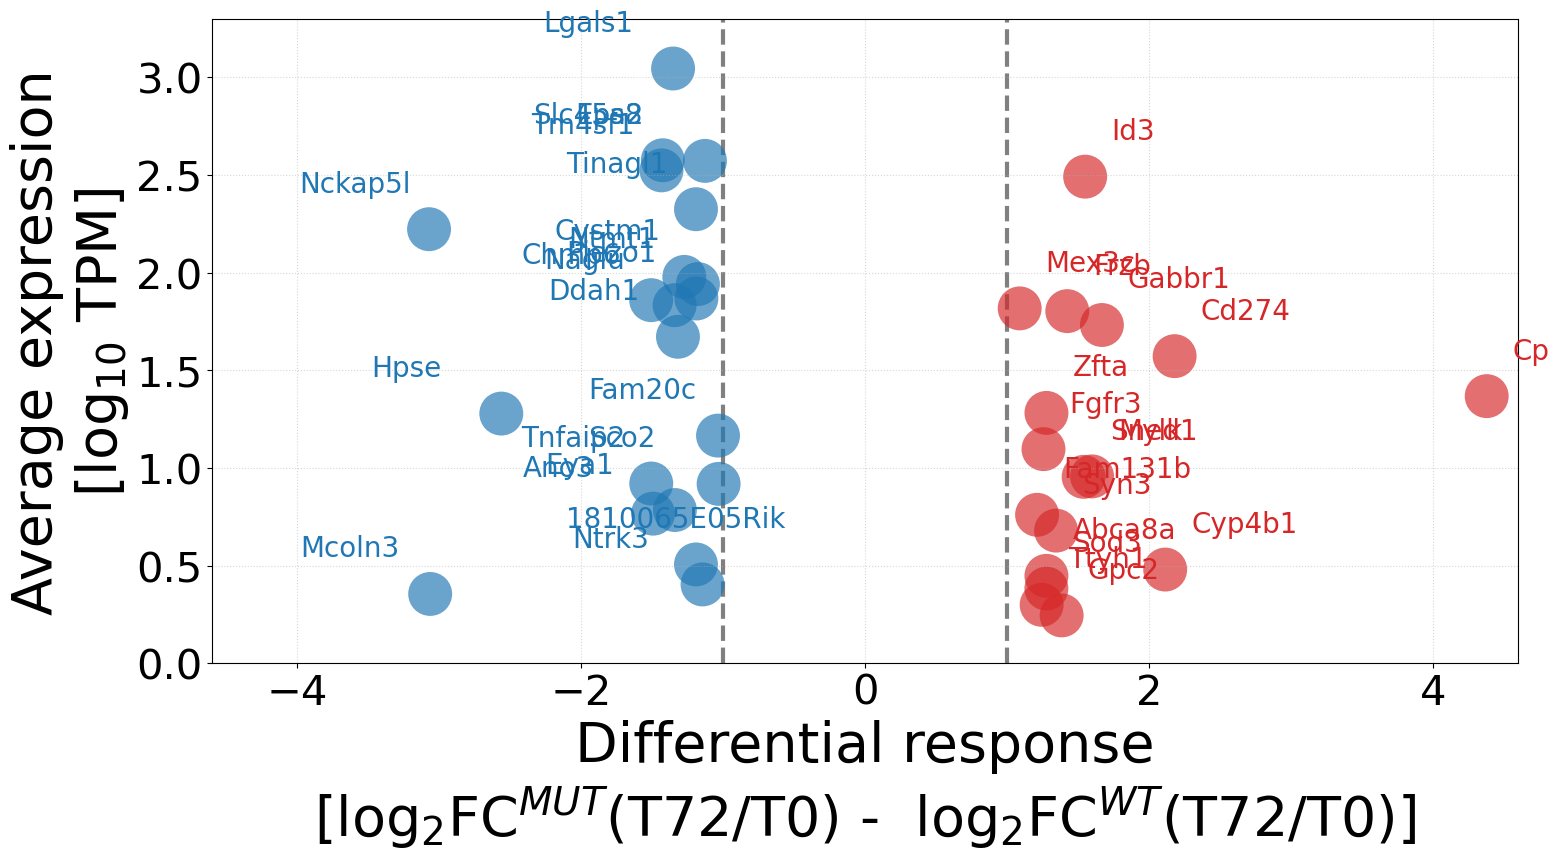

In [16]:
for i in range(len(strong_pattern_genes)):
    ensembl = strong_pattern_genes[i]
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    locx = locations[ensembl][0]
    locy = locations[ensembl][1]
    
    if locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()

## 5.1. scatter plot for weak pattern

Lgals1	-1.354	3.046	tab:blue
Txnrd2	-0.827	1.120	gray
Tm4sf1	-1.436	2.524	tab:blue
Tox3	0.859	1.016	gray
Mex3c	1.088	1.818	tab:red
Mindy2	-0.747	1.737	gray
Cyp4b1	2.113	0.480	tab:red
Ttyh1	1.243	0.300	tab:red
Sco2	-1.033	0.919	tab:blue
Gabbr1	1.668	1.732	tab:red
Aif1l	-0.662	1.081	gray
Card19	-0.604	1.748	gray
Id3	1.549	2.492	tab:red
Fxyd1	0.977	1.153	gray
Pdlim2	0.564	0.804	gray
Mcoln3	-3.065	0.355	tab:blue
Atp6v1g1	-0.916	2.643	gray
Ddah1	-1.319	1.672	tab:blue
Fam20c	-1.037	1.166	tab:blue
1810065E05Rik	-1.193	0.506	tab:blue
Hpse	-2.564	1.279	tab:blue
Frzb	1.424	1.803	tab:red
Sipa1l2	0.667	1.408	gray
Fgfr3	1.256	1.097	tab:red
Slc45a2	-1.426	2.576	tab:blue
Sned1	1.539	0.955	tab:red
Cp	4.379	1.368	tab:red
Mknk2	-0.880	2.011	gray
Cbfa2t3	-0.628	0.729	gray
Sod3	1.276	0.383	tab:red
Naglu	-1.343	1.834	tab:blue
Fyb	0.994	0.591	gray
Mfsd11	-0.589	1.729	gray
Zfta	1.277	1.282	tab:red
Ntrk3	-1.146	0.404	tab:blue
Ano3	-1.495	0.766	tab:blue
Atp6v0a1	-0.690	2.272	gray
Cystm1	-1.275	1.979	tab:blue
P

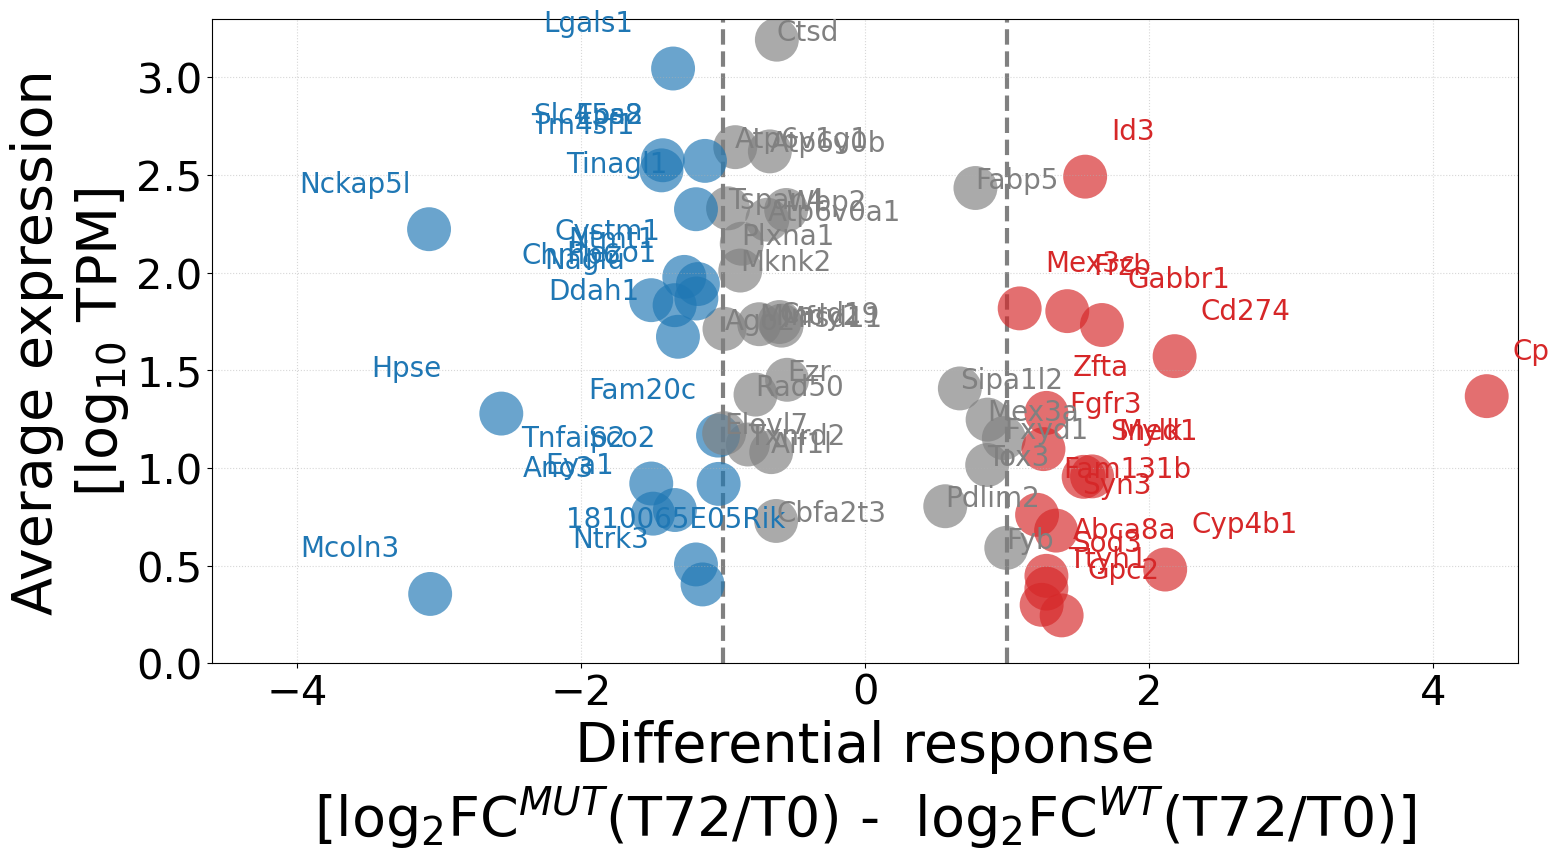

In [17]:
info = {}

for i in range(len(weak_pattern_genes)):
    ensembl = weak_pattern_genes[i]
    
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description']
    locx = locations[ensembl][0]
    locy = locations[ensembl][1]
    info[ensembl] = [gene_name, description, locx, locy]
    
    if -1 < locx < 1:
        the_color = 'gray'
        matplotlib.pyplot.text(locx, locy, gene_name, color=the_color)
    elif locx > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(locx+(11/60), locy+(11.5/60), gene_name, color=the_color)
    elif locx < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(locx-(11/12), locy+(11.5/60), gene_name, color=the_color)
    else:
        print(locx)
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(locx, locy, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_name, '{:.3f}'.format(locx), '{:.3f}'.format(locy), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 3.3])
matplotlib.pyplot.tight_layout()

In [18]:
df = pandas.DataFrame.from_dict(info, orient='index', columns=['Gene name', 'Description', 'Response difference', 'Expression [log10 TPM]'])
df.sort_values(by='Response difference', inplace=True, ascending=False)

In [19]:
reds = df[df['Response difference'] > 1]
print(reds.shape)
reds

(17, 4)


,Gene name,Description,Response difference,Expression [log10 TPM]
ENSMUSG00000003617,Cp,ceruloplasmin [Source:MGI Symbol;Acc:MGI:88476],4.378652,1.368154
ENSMUSG00000016496,Cd274,CD274 antigen [Source:MGI Symbol;Acc:MGI:1926446],2.179817,1.572902
ENSMUSG00000028713,Cyp4b1,"cytochrome P450, family 4, subfamily b, polype...",2.113390,0.480160
ENSMUSG00000024462,Gabbr1,"gamma-aminobutyric acid (GABA) B receptor, 1 [...",1.667538,1.732430
ENSMUSG00000022836,Mylk,"myosin, light polypeptide kinase [Source:MGI S...",1.598179,0.957172
ENSMUSG00000007872,Id3,inhibitor of DNA binding 3 [Source:MGI Symbol;...,1.549490,2.492054
ENSMUSG00000047793,Sned1,"sushi, nidogen and EGF-like domains 1 [Source:...",1.538840,0.954916
ENSMUSG00000027004,Frzb,frizzled-related protein [Source:MGI Symbol;Ac...,1.423590,1.803436
ENSMUSG00000029510,Gpc2,glypican 2 (cerebroglycan) [Source:MGI Symbol;...,1.383874,0.245449
ENSMUSG00000059602,Syn3,synapsin III [Source:MGI Symbol;Acc:MGI:1351334],1.344674,0.679562


In [20]:
greys = df[(df['Response difference'] < 1) & (df['Response difference'] > -1)]
greys['Absolute response difference'] = greys['Response difference'].abs()
greys.sort_values(by='Absolute response difference', inplace=True, ascending=False)
print(greys.shape)
greys

(25, 5)


/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_9560/3600193276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greys['Absolute response difference'] = greys['Response difference'].abs()
/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_9560/3600193276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greys.sort_values(by='Absolute response difference', inplace=True, ascending=False)


,Gene name,Description,Response difference,Expression [log10 TPM],Absolute response difference
ENSMUSG00000021696,Elovl7,"ELOVL family member 7, elongation of long chai...",-0.994068,1.178560,0.994068
ENSMUSG00000022148,Fyb,FYN binding protein [Source:MGI Symbol;Acc:MGI...,0.993686,0.591163,0.993686
ENSMUSG00000036698,Ago2,argonaute RISC catalytic subunit 2 [Source:MGI...,-0.991636,1.712594,0.991636
ENSMUSG00000036570,Fxyd1,FXYD domain-containing ion transport regulator...,0.976613,1.153035,0.976613
ENSMUSG00000025511,Tspan4,tetraspanin 4 [Source:MGI Symbol;Acc:MGI:1928097],-0.966359,2.329885,0.966359
ENSMUSG00000039105,Atp6v1g1,"ATPase, H+ transporting, lysosomal V1 subunit ...",-0.915649,2.643089,0.915649
ENSMUSG00000020190,Mknk2,MAP kinase-interacting serine/threonine kinase...,-0.880405,2.011146,0.880405
ENSMUSG00000030084,Plxna1,plexin A1 [Source:MGI Symbol;Acc:MGI:107685],-0.870064,2.148646,0.870064
ENSMUSG00000074480,Mex3a,mex3 RNA binding family member A [Source:MGI S...,0.862120,1.247971,0.862120
ENSMUSG00000043668,Tox3,TOX high mobility group box family member 3 [S...,0.859260,1.015523,0.859260


In [21]:
blues = df[df['Response difference'] < -1]
print(blues.shape)
blues.sort_values(by='Response difference', inplace=True)
blues

(21, 4)


/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_9560/2617783875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blues.sort_values(by='Response difference', inplace=True)


,Gene name,Description,Response difference,Expression [log10 TPM]
ENSMUSG00000023009,Nckap5l,NCK-associated protein 5-like [Source:MGI Symb...,-3.073079,2.223028
ENSMUSG00000036853,Mcoln3,mucolipin 3 [Source:MGI Symbol;Acc:MGI:1890500],-3.065219,0.355246
ENSMUSG00000035273,Hpse,heparanase [Source:MGI Symbol;Acc:MGI:1343124],-2.564071,1.278858
ENSMUSG00000025371,Chmp6,charged multivesicular body protein 6 [Source:...,-1.507994,1.859575
ENSMUSG00000021281,Tnfaip2,"tumor necrosis factor, alpha-induced protein 2...",-1.507551,0.920718
ENSMUSG00000074968,Ano3,anoctamin 3 [Source:MGI Symbol;Acc:MGI:3613666],-1.494588,0.766398
ENSMUSG00000027800,Tm4sf1,transmembrane 4 superfamily member 1 [Source:M...,-1.435564,2.524238
ENSMUSG00000022243,Slc45a2,"solute carrier family 45, member 2 [Source:MGI...",-1.426324,2.576053
ENSMUSG00000068220,Lgals1,"lectin, galactose binding, soluble 1 [Source:M...",-1.353782,3.045815
ENSMUSG00000001751,Naglu,alpha-N-acetylglucosaminidase (Sanfilippo dise...,-1.342987,1.833961


# 6. identify enrichment

In [22]:
for ensembl in strong_pattern_genes:
    print(ensembl)

ENSMUSG00000068220
ENSMUSG00000027800
ENSMUSG00000037253
ENSMUSG00000028713
ENSMUSG00000030428
ENSMUSG00000091780
ENSMUSG00000024462
ENSMUSG00000007872
ENSMUSG00000036853
ENSMUSG00000028194
ENSMUSG00000025854
ENSMUSG00000013653
ENSMUSG00000035273
ENSMUSG00000027004
ENSMUSG00000054252
ENSMUSG00000022243
ENSMUSG00000047793
ENSMUSG00000003617
ENSMUSG00000072941
ENSMUSG00000001751
ENSMUSG00000053080
ENSMUSG00000059146
ENSMUSG00000074968
ENSMUSG00000046727
ENSMUSG00000059602
ENSMUSG00000041828
ENSMUSG00000022836
ENSMUSG00000023009
ENSMUSG00000014444
ENSMUSG00000021281
ENSMUSG00000028776
ENSMUSG00000015766
ENSMUSG00000016496
ENSMUSG00000025932
ENSMUSG00000029510
ENSMUSG00000026857
ENSMUSG00000029861
ENSMUSG00000025371


Mus musculus (REF)	upload_1 ( Hierarchy  NEW! Tips)  
Reactome pathways	#	#	expected	Fold Enrichment	+/-	P value  
HS-GAG degradation	22	3	.04	85.70	+	1.37E-02  
Unclassified	12955	12	20.61	.58	-	0.00E00  


Naglu, Gpc2 and Hpse.

# 6. build heatmap

In [23]:
container = {}
for ensembl in strong_pattern_genes:
    full = numpy.concatenate((fitted_trajectory_mut[ensembl], fitted_trajectory_wt[ensembl]), axis=0)
    container[ensembl] = full
    
df = pandas.DataFrame.from_dict(container, orient='index', columns=['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h'])
df.head()

new_index = {}
for ensembl in df.index:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

In [24]:
zscore_df = scipy.stats.zscore(df, axis=1)
zscore_df.head()

,MUT_0h,MUT_48h,MUT_72h,WT_0h,WT_48h,WT_72h
Lgals1,0.370916,-1.007699,-1.697006,1.078339,0.717847,0.537602
Tm4sf1,0.761890,-0.920091,-1.761082,0.258925,0.715929,0.944430
Mex3c,-0.320954,1.028269,1.702881,-0.757747,-0.812529,-0.839920
Cyp4b1,-2.110162,-0.142640,0.841121,0.166711,0.531330,0.713640
Ttyh1,-0.355924,1.023563,1.713307,-0.812277,-0.789923,-0.778746


In [25]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

2.079288560278588
-2.121559266991263


In [26]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

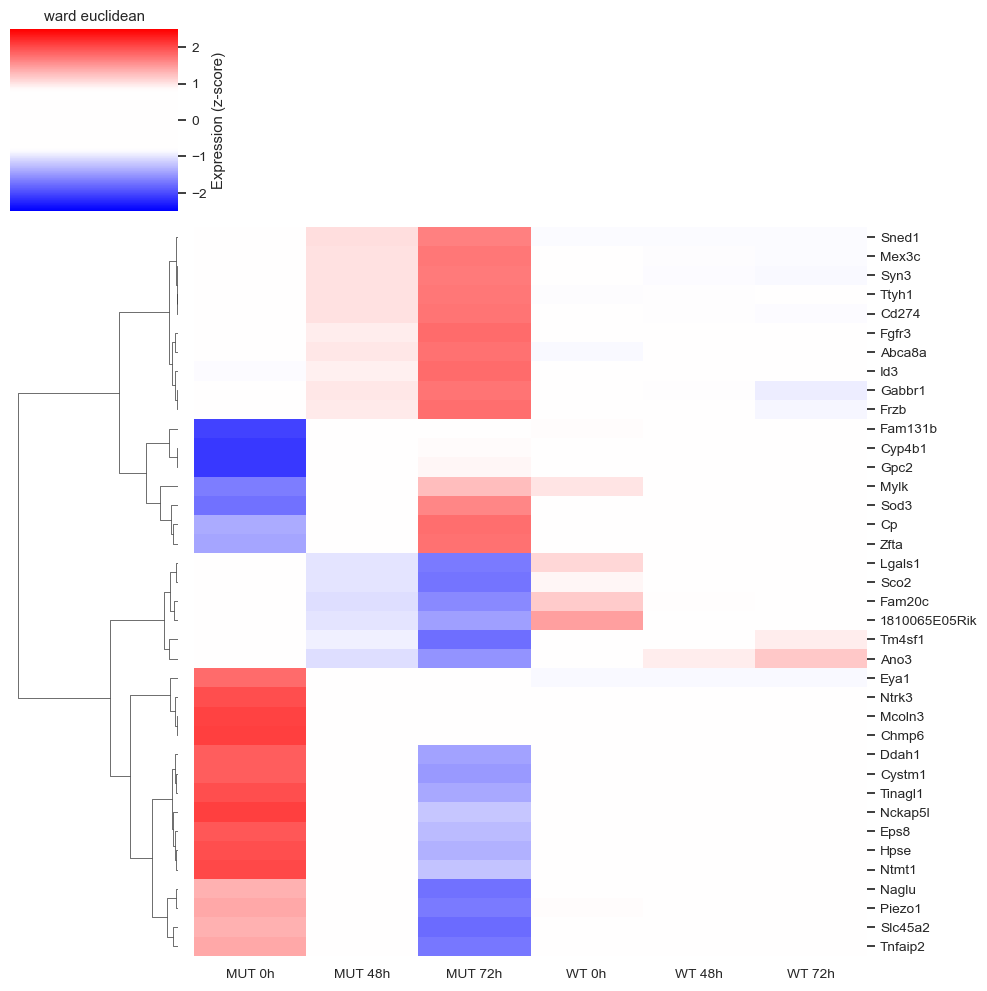

In [27]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

h = seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

ordered_gene_names = [element.get_text() for element in h.ax_heatmap.get_yticklabels()]

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

#matplotlib.pyplot.savefig('heatmap.svg')

# 7.build dynamics

In [28]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':12, 'font.family':'sans-serif', 'xtick.labelsize':12, 'ytick.labelsize':12, 'figure.figsize':(16/2, 9/2), 'axes.labelsize':12})

In [29]:
strong_pattern_gene_names = [annotation.loc[ensembl]['ext_gene'] for ensembl in strong_pattern_genes]
strong_pattern_gene_names.sort()

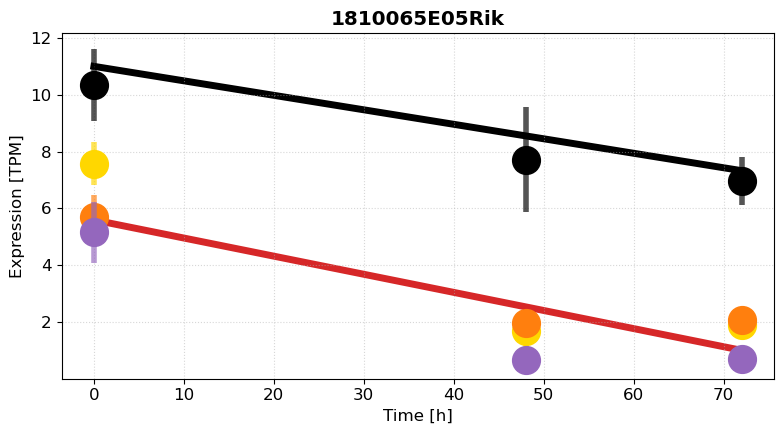

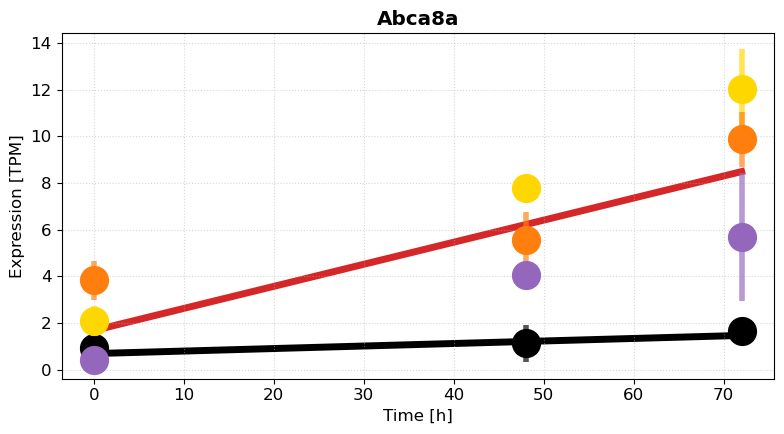

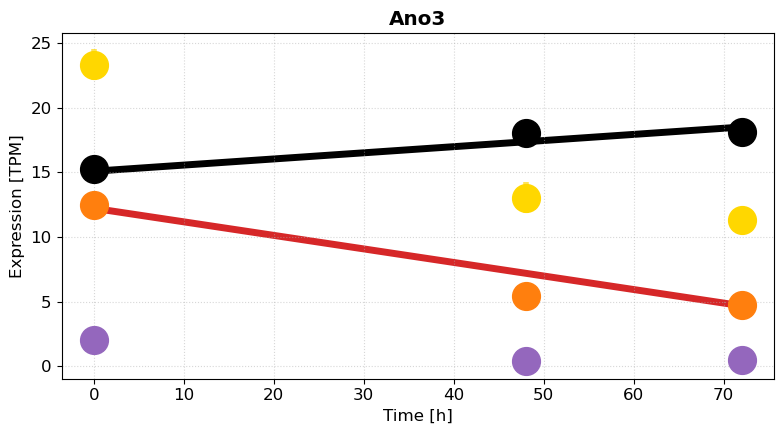

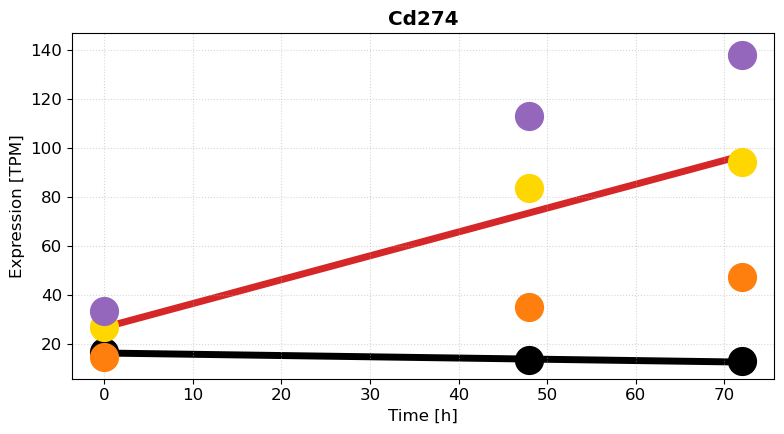

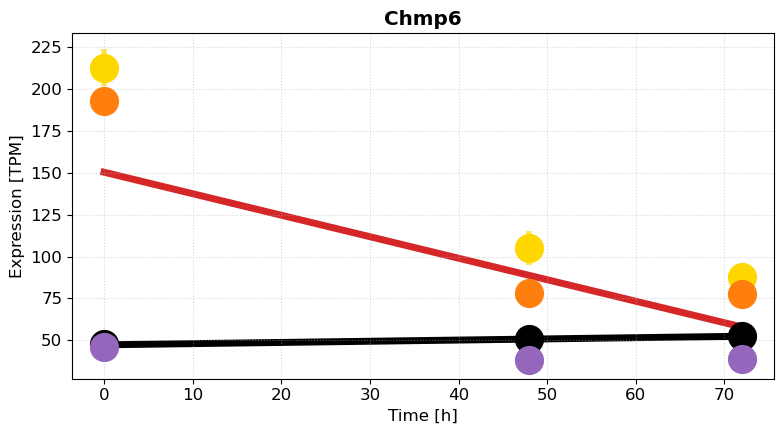

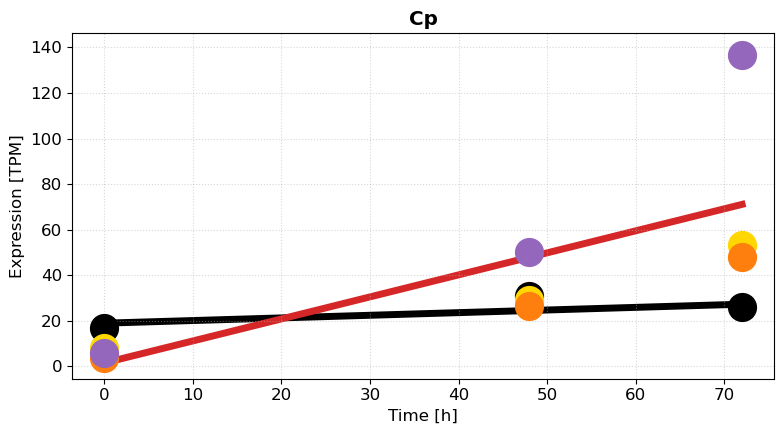

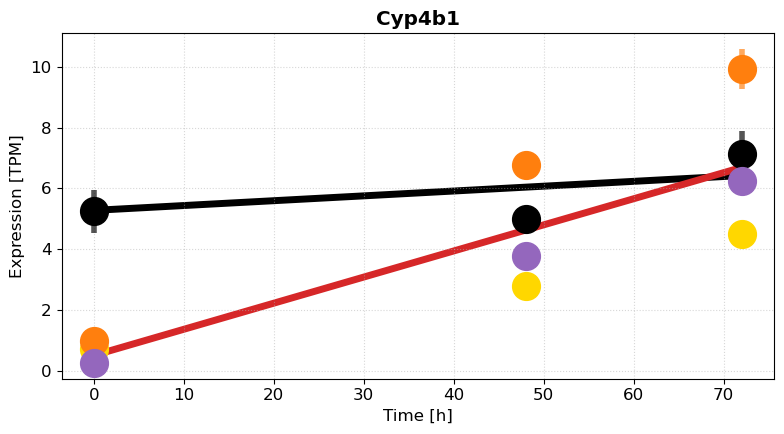

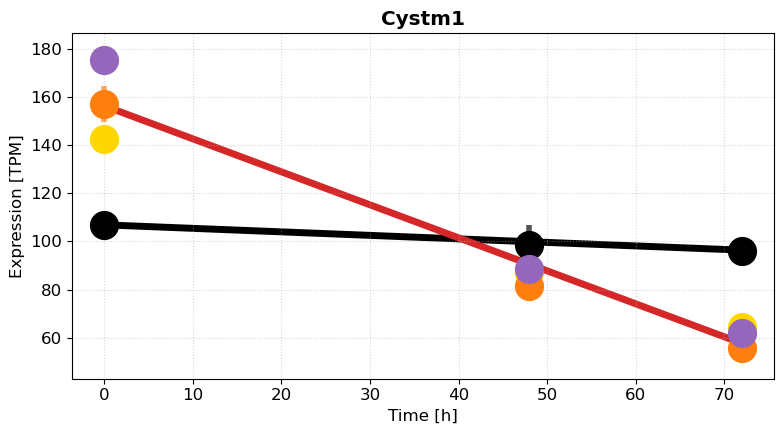

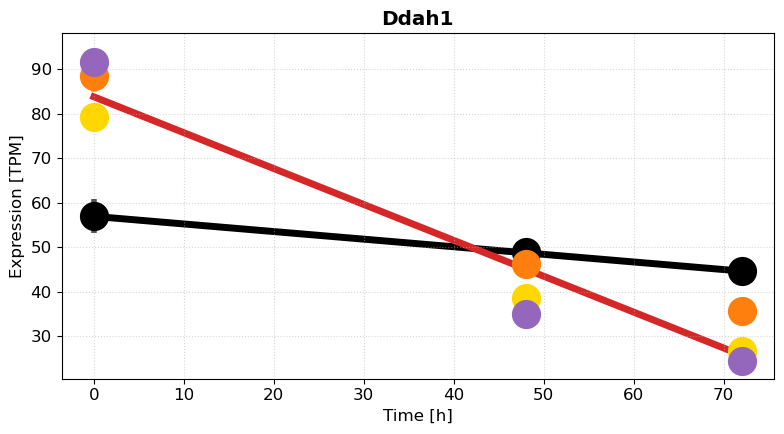

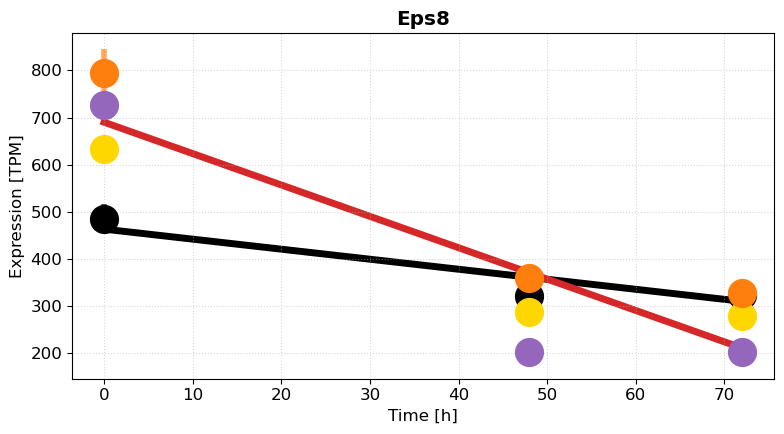

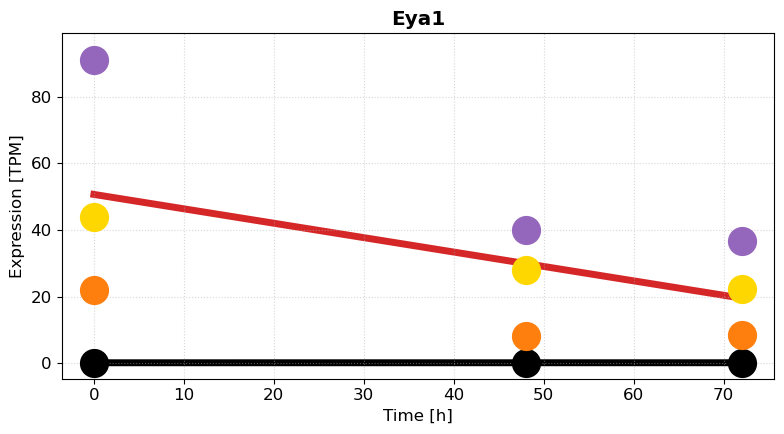

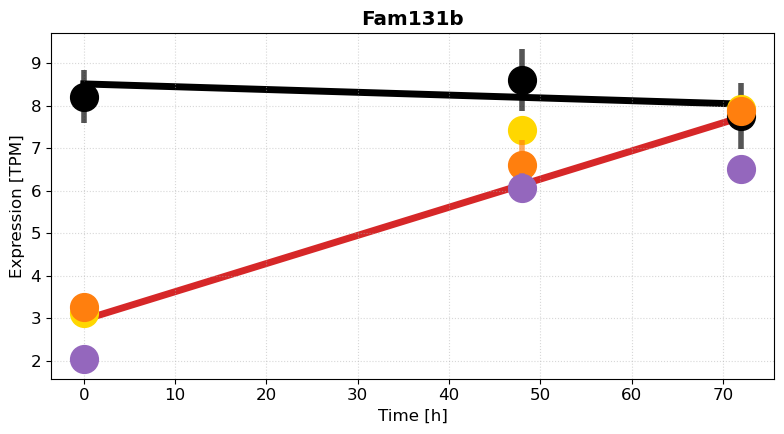

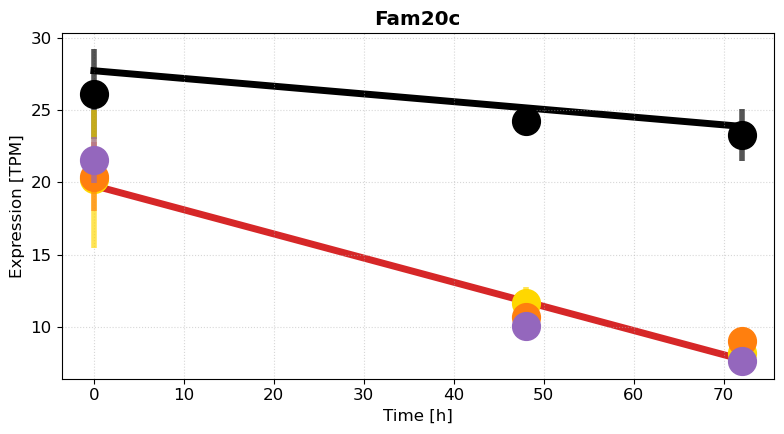

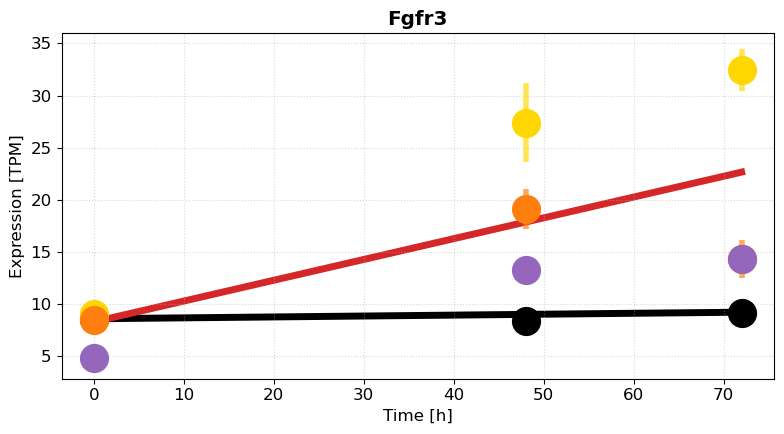

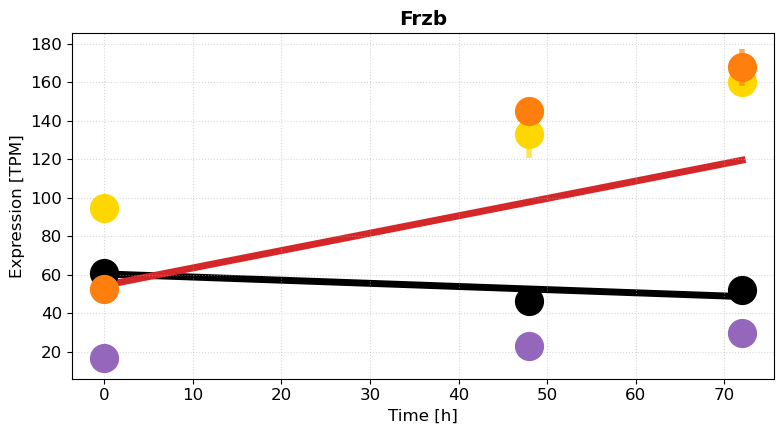

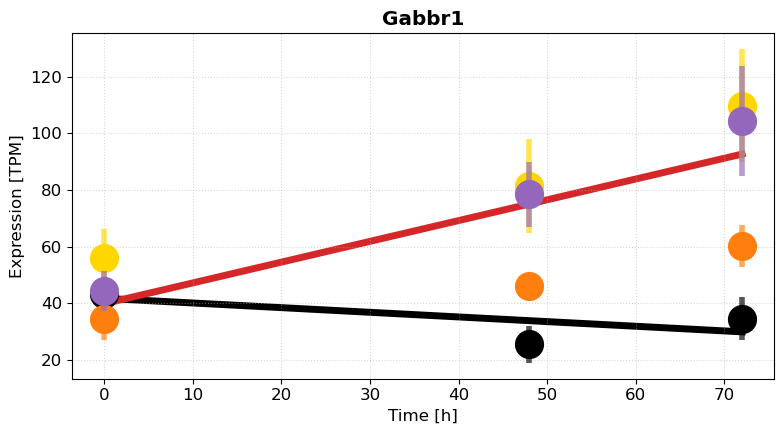

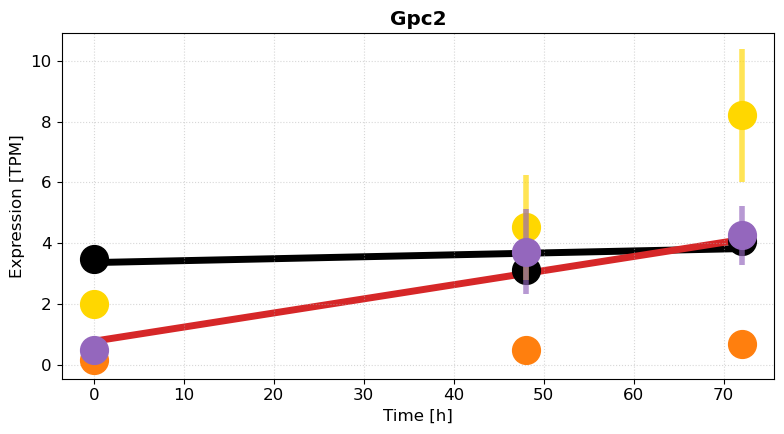

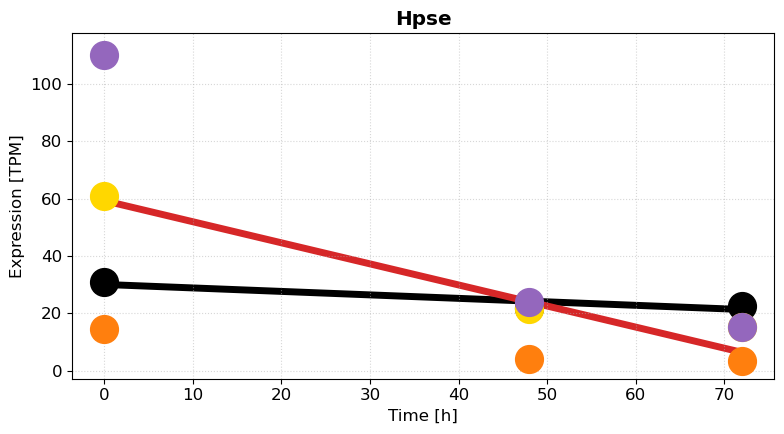

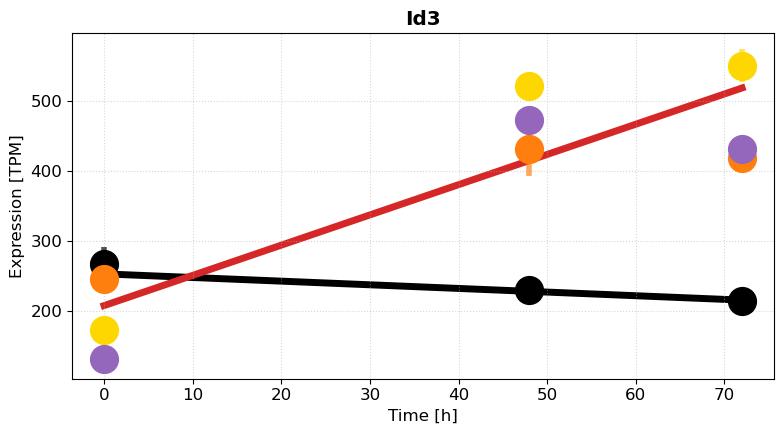

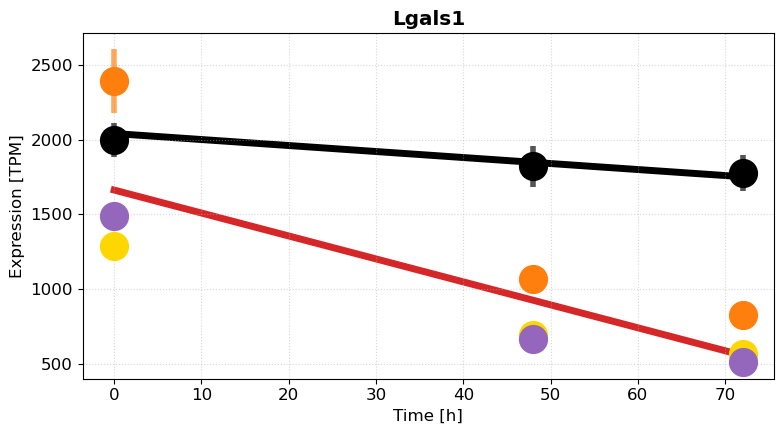

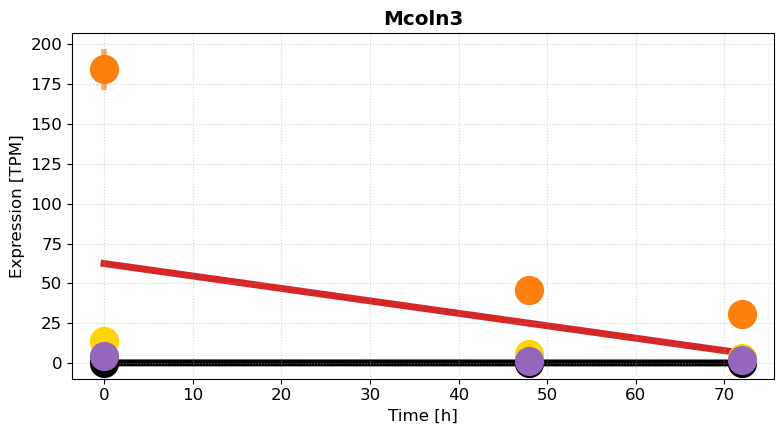

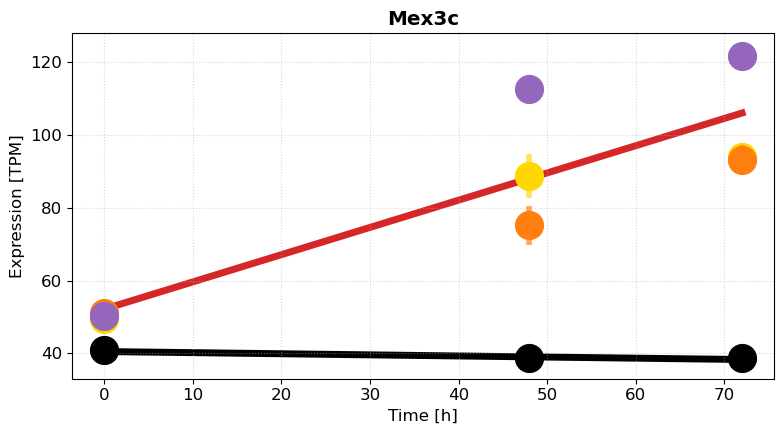

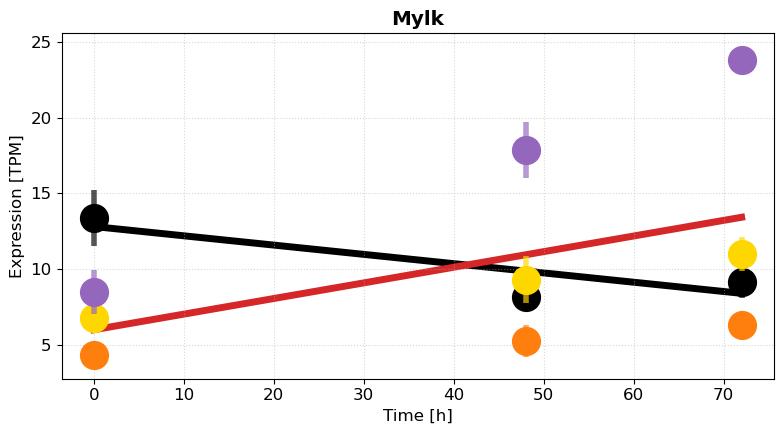

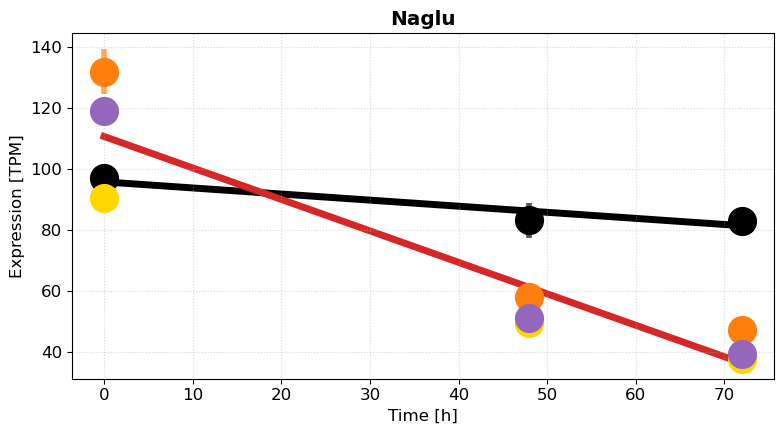

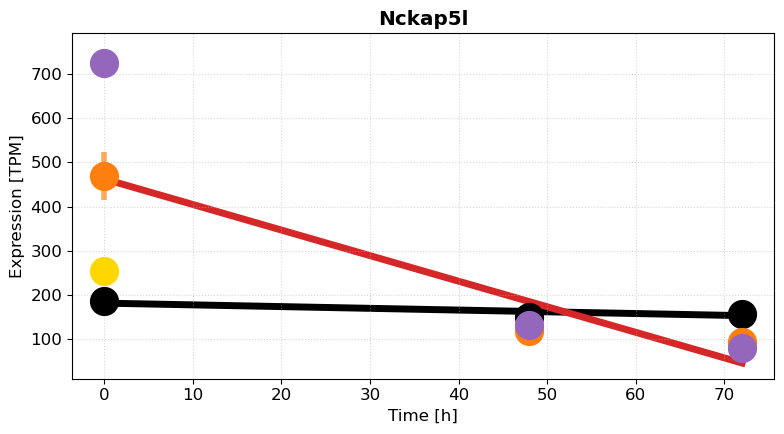

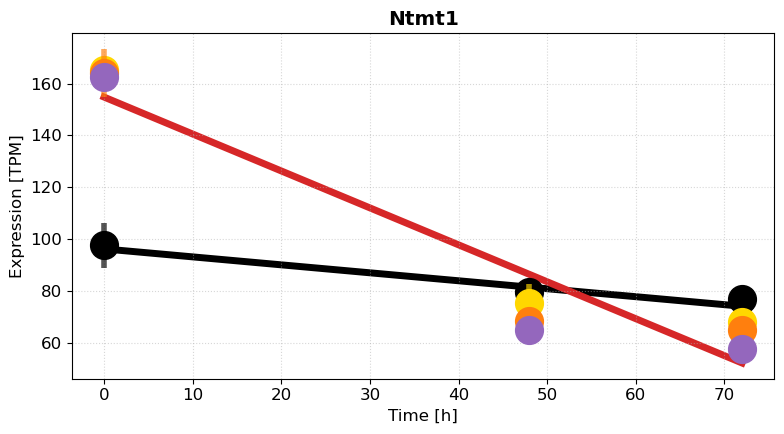

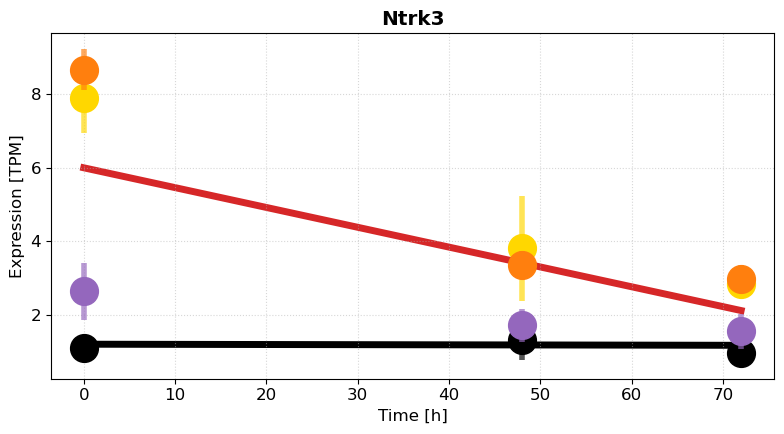

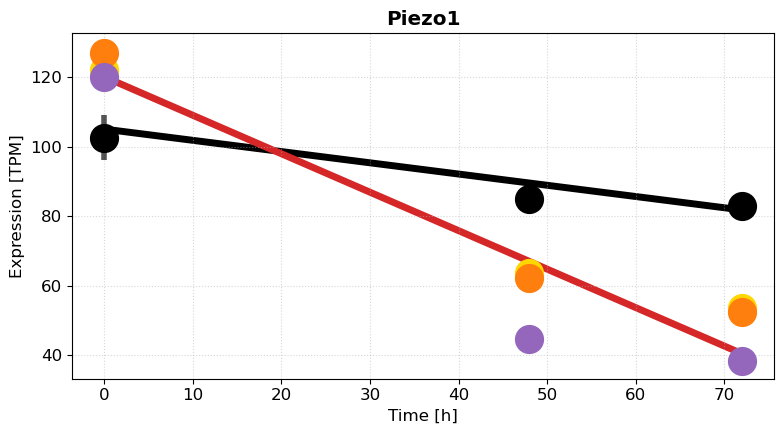

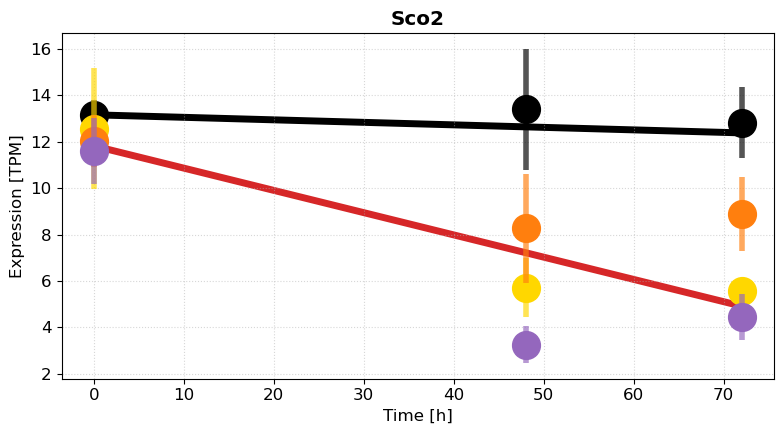

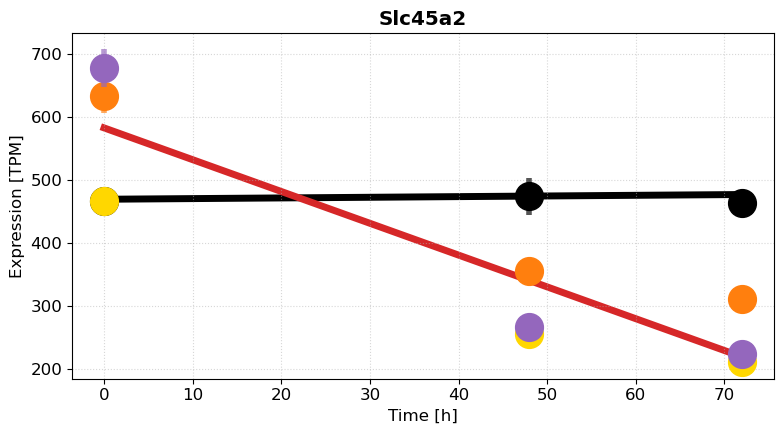

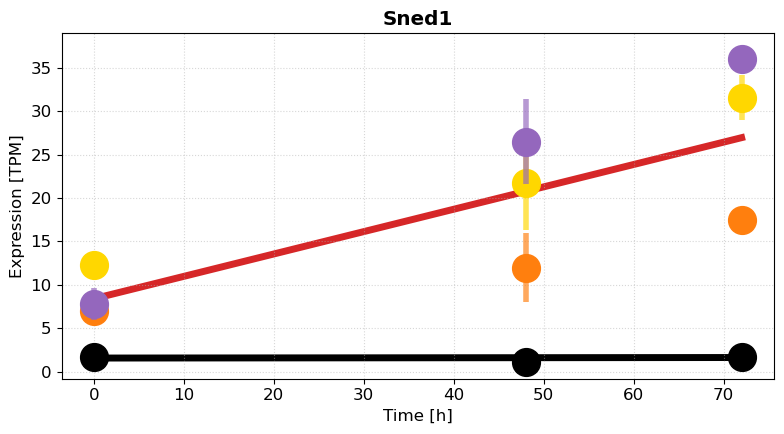

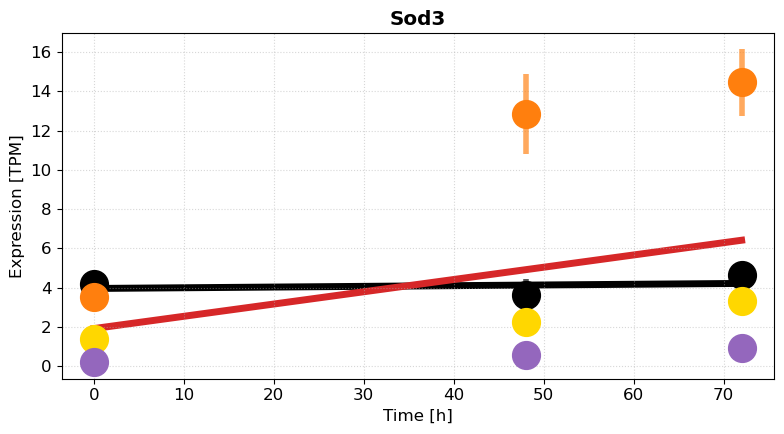

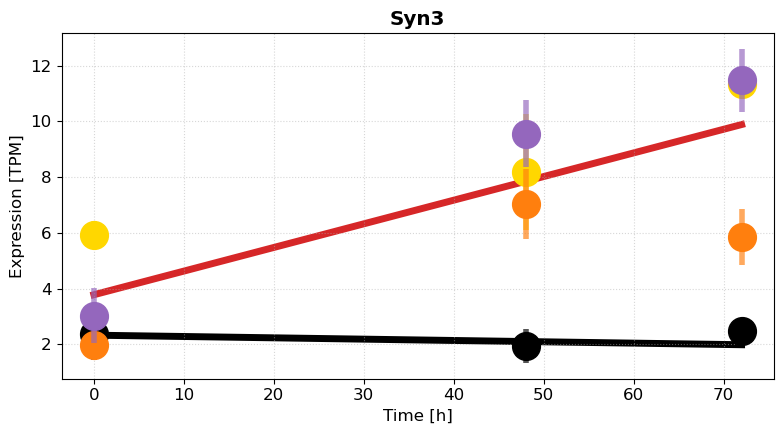

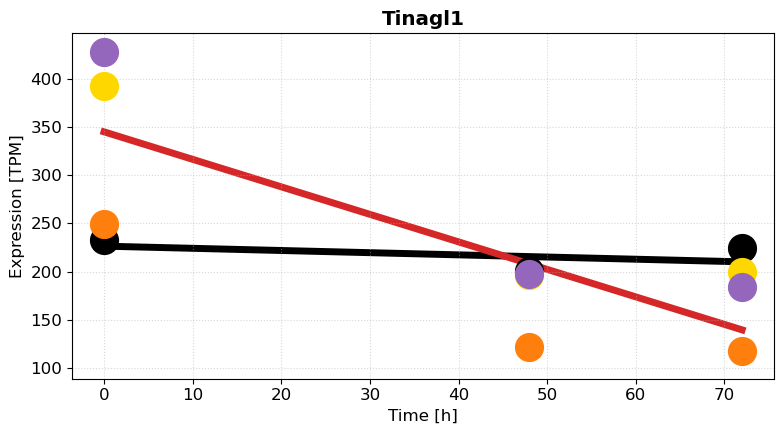

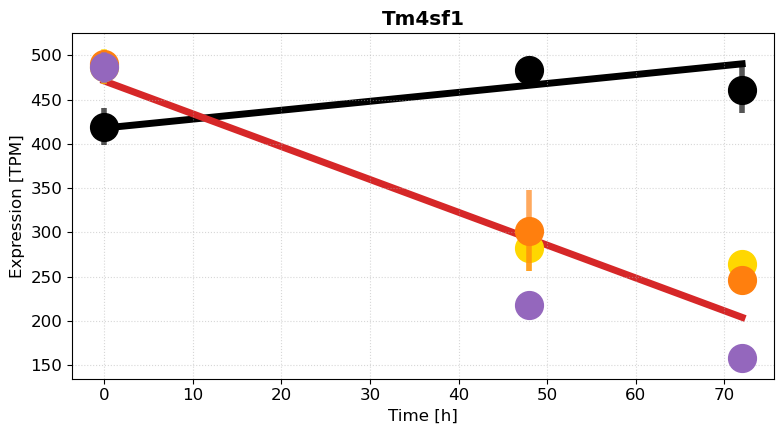

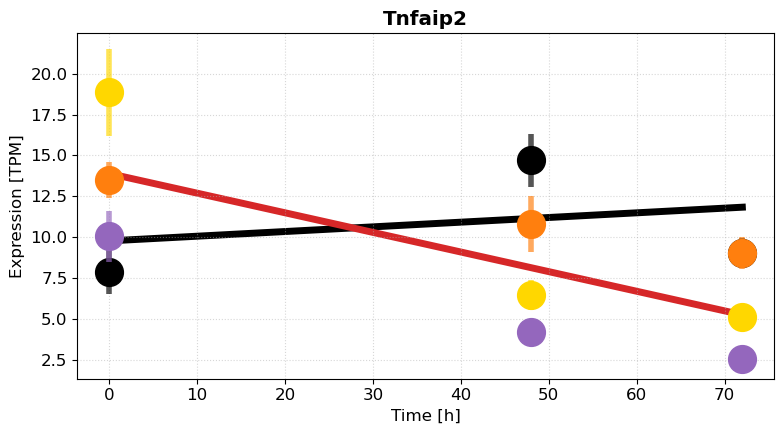

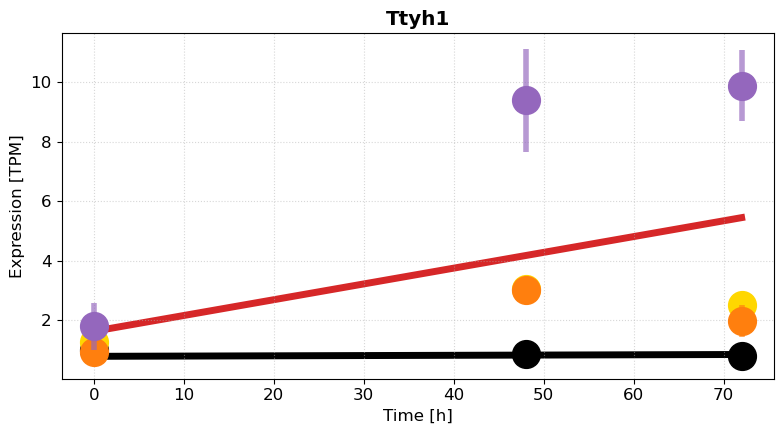

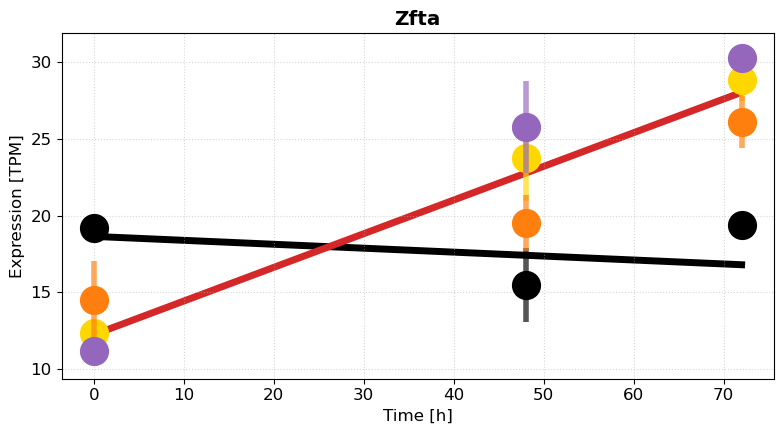

In [30]:
for gene_name in strong_pattern_gene_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    ensembl_trajectory = []; ensembl_times = []
    for mouse in mice:
        
        ### plot error bars based on mean and std values
        plotting_means = []
        plotting_stds = []
        for time in times:
            working_labels = [label for label in expression.columns if mouse in label and time in label]
            #print(working_labels)
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
        
    ### plot the regression lines based on mice expresssion
    labels = [label for label in mice_expression.columns if 'a3922' in label]
    labels.sort()    
    y = mice_expression.loc[ensembl, labels].values
    t = numpy.array(numerical_times)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(t, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    matplotlib.pyplot.plot(t, fitted_y, '-', color='black', lw=5, zorder=0)
    
    labels = [label for label in mice_expression.columns if 'a3922' not in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
        
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    matplotlib.pyplot.plot(t, fitted_y, '-', color='tab:red', lw=5, zorder=0)
        
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

# Appendix 1 --- Analysis for direct targets

In [31]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

(386758, 4)


,tf,confidence,target,mor
1,4932411N23Rik,E,Smad4,1
2,4932411N23Rik,E,0610030E20Rik,1
3,4932411N23Rik,E,1700017N19Rik,1
4,4932411N23Rik,E,4931428F04Rik,1
5,4932411N23Rik,E,4932438A13Rik,1


In [32]:
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

(37, 4)


,tf,confidence,target,mor
134897,Mitf,A,Acp5,1
134898,Mitf,A,Apex1,1
134899,Mitf,A,Bcl2,1
134900,Mitf,A,Bcl2a1a,-1
134901,Mitf,A,Bcl2a1b,-1


In [33]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

37


In [34]:
# define intersect
print(len(direct_targets_names), direct_targets_names)
print(len(strong_pattern_gene_names), strong_pattern_gene_names)
successes = list(set(direct_targets_names) & set(strong_pattern_gene_names))
print(successes)

37 ['Acp5', 'Apex1', 'Bcl2', 'Bcl2a1a', 'Bcl2a1b', 'Bcl2a1c', 'Bcl2a1d', 'Best1', 'Birc7', 'Cdk2', 'Clcn7', 'Ctsk', 'Dct', 'Diaph1', 'Fos', 'Gpnmb', 'Gpr143', 'Herc2', 'Hif1a', 'Hoxb4', 'Itpr1', 'Kit', 'Mapre2', 'Met', 'Mlana', 'Oca2', 'Pmel', 'Ppargc1a', 'Prkcb', 'Rab27a', 'Serpinf1', 'Snai2', 'Stard13', 'Tbc1d1', 'Trpm1', 'Tyr', 'Tyrp1']
38 ['1810065E05Rik', 'Abca8a', 'Ano3', 'Cd274', 'Chmp6', 'Cp', 'Cyp4b1', 'Cystm1', 'Ddah1', 'Eps8', 'Eya1', 'Fam131b', 'Fam20c', 'Fgfr3', 'Frzb', 'Gabbr1', 'Gpc2', 'Hpse', 'Id3', 'Lgals1', 'Mcoln3', 'Mex3c', 'Mylk', 'Naglu', 'Nckap5l', 'Ntmt1', 'Ntrk3', 'Piezo1', 'Sco2', 'Slc45a2', 'Sned1', 'Sod3', 'Syn3', 'Tinagl1', 'Tm4sf1', 'Tnfaip2', 'Ttyh1', 'Zfta']
[]


In [35]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

#  plot the behaviour of the Mitf direct target genes

catt = numpy.concatenate((numerical_times, numerical_times, numerical_times), axis=0)

fitted_trajectory_wt = {}; fitted_trajectory_mut = {}

for gene_name in direct_targets_names:
    
    ensembl = annotation[annotation['ext_gene'] == gene_name].index[0]
    
    ### determine fitted response in WT
    labels = [label for label in mice_expression.columns if 'a3922' in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(numerical_times, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_response_wt = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_trajectory_wt[ensembl] = fitted_y
    
    ### determine fitted response in MUT
    labels = [label for label in mice_expression.columns if 'a3922' not in label]
    labels.sort()
    y = mice_expression.loc[ensembl, labels].values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catt, y)
    fitted_y = slope*t + intercept
    fitted_y[fitted_y < 0] = 0
    fitted_response_mut = numpy.log2((fitted_y[-1]+1) / (fitted_y[0]+1))
    fitted_trajectory_mut[ensembl] = fitted_y
    
    # plot
    delta =  fitted_response_mut - fitted_response_wt
    average_expression = numpy.mean(numpy.log10(mice_expression.loc[ensembl, :]+1))
    if delta > 1:
        the_color = 'tab:red'
    elif delta < -1:
        the_color = 'tab:blue'
    else:
        the_color = 'grey'
    matplotlib.pyplot.scatter(delta, average_expression, s=1000, c=the_color, alpha=2/3, edgecolor='none')
    if average_expression > 0.5:
        matplotlib.pyplot.text(delta, average_expression, gene_name, color=the_color)
    
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-4.6, 4.6])
matplotlib.pyplot.ylim([0, 4.5])
matplotlib.pyplot.tight_layout()

In [36]:
# heatmap
container = {}

for gene_name in direct_targets_names:
    
    ensembl = annotation[annotation['ext_gene'] == gene_name].index[0]
    #print(ensembl, fitted_trajectory_mut[ensembl])
    full = numpy.concatenate((fitted_trajectory_mut[ensembl], fitted_trajectory_wt[ensembl]), axis=0)
    container[ensembl] = full
    #print(container[ensembl])
    
df = pandas.DataFrame.from_dict(container, orient='index', columns=['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h'])
df.head()

new_index = {}
for ensembl in df.index:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

In [37]:
zscore_df = scipy.stats.zscore(df, axis=1)
zscore_df.fillna(0, inplace=True)
zscore_df.head()

,MUT_0h,MUT_48h,MUT_72h,WT_0h,WT_48h,WT_72h
Acp5,0.832011,-0.600224,-1.316342,1.657723,0.102278,-0.675445
Apex1,-1.322752,-0.462034,-0.031675,-0.716490,0.869882,1.663068
Bcl2,-0.596604,-1.054551,-1.283524,1.068762,0.960119,0.905798
Bcl2a1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bcl2a1b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
working line

SyntaxError: invalid syntax (1511224689.py, line 1)

# Appendix 2 --- identify the number of filtered DEGs that separate time and biological differences.

## A.2.1. PCA on top highly expressed genes

## A.2.2. for time, retain union of time for each mouse.

## A.2.3. for biological differences, retain union of WT vs each MUT